In [1]:
# Whatever you don't have, install (pip or conda)
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
import time
import geopy
from geopy.distance import geodesic
import geopandas as gpd
import shapely
import numpy as np

In [2]:
spark = SparkSession.builder.appName('Yelp Data').config("spark.some.config.option", "some-value").getOrCreate() # For dataframes

In [3]:
business_json_path = 'yelp_academic_dataset_business.json' # Change paths to whatever
user_json_path = 'yelp_academic_dataset_user.json'
review_json_path = 'yelp_academic_dataset_review.json'

In [4]:
start = time.time()   # Read in JSON as Spark Dataframe and count the time
print("User Start-time=\t{0}".format(time.ctime(start)))
busDF = spark.read.json(business_json_path)
end = time.time()
print("User End-time=\t{0}".format(time.ctime(end)))
print("Time elapsed=\t{0} s".format(end-start))

User Start-time=	Fri Dec  4 18:49:42 2020
User End-time=	Fri Dec  4 18:49:46 2020
Time elapsed=	4.518556594848633 s


In [5]:
busDF.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [6]:
start = time.time()
print("User Start-time=\t{0}".format(time.ctime(start)))
userDF = spark.read.json(user_json_path)
end = time.time()
print("User End-time=\t{0}".format(time.ctime(end)))
print("Time elapsed=\t{0} s".format(end-start))

User Start-time=	Fri Dec  4 18:50:04 2020
User End-time=	Fri Dec  4 18:50:23 2020
Time elapsed=	19.027873039245605 s


In [7]:
userDF.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [8]:
start = time.time()
print("Review Start-time={0}\t".format(time.ctime(start)))
reviewDF = spark.read.json(review_json_path)
end = time.time()
print("Review End-time={0}\t".format(time.ctime(end)))
print("Time elapsed={0}\t".format(end-start))

Review Start-time=Fri Dec  4 18:51:13 2020	
Review End-time=Fri Dec  4 18:51:32 2020	
Time elapsed=18.866640090942383	


In [9]:
reviewDF.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [10]:
# Sort open restaurants by latitude & longitude in ascending order
rdf = busDF.filter(busDF['is_open']==True).filter(busDF.categories.contains('Restaurant')).orderBy(['latitude','longitude'])

In [11]:
print("Total Businesses: {0}".format(busDF.count()))
print("Total Open Restaurants: {0}".format(rdf.count()))

Total Businesses: 209393
Total Open Restaurants: 43980


In [15]:
rdf.columns

['address',
 'attributes',
 'business_id',
 'categories',
 'city',
 'hours',
 'is_open',
 'latitude',
 'longitude',
 'name',
 'postal_code',
 'review_count',
 'stars',
 'state']

In [17]:
rdf_pd = rdf.toPandas().sort_values(by=['latitude','longitude']) # Convert to pandas for finding neighboring restaurants within a radius

In [18]:
rdf_pd

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,"8225 W Indian School Rd, Ste 1","(None, None, 'none', {'romantic': False, 'inti...",jSoXCOgEZ97KSaMsbiJdPg,"Pizza, Restaurants, Italian, Chicken Wings",Wahiawa,"(10:0-23:0, 10:0-22:0, 10:0-23:0, 10:0-22:0, 1...",1,21.497258,-158.025525,Pizza Hut,96786,51,2.0,HI
1,8091 Broadway,"(None, None, u'none', {'romantic': False, 'int...",wp4_fzgPHKqJX8k4eedcvw,"Chicken Wings, Restaurants, Pizza, Italian",Lemon Grove,"(11:0-0:0, 11:0-23:0, 11:0-0:0, 11:0-23:0, 11:...",1,32.742443,-117.023600,Pizza Hut,91945,59,2.0,CA
2,10841 E San Tan Blvd,"(None, None, None, {'touristy': False, 'hipste...",j0_gBQTGWhhYAYhK4D83Cw,"Restaurants, American (Traditional)",Sun Lakes,None,1,33.210781,-111.847473,Palo Verde Restaurant,85248,8,4.0,AZ
3,6250 S Sunbird Blvd,"(None, None, None, None, None, None, None, Non...",T_1Q5-7yUyAW5jFe2N8eUg,"Restaurants, American (Traditional)",Chandler,"(7:30-18:0, 7:30-18:0, 7:30-18:0, 8:0-18:0, 7:...",1,33.215398,-111.809608,Horizon Room,85249,6,4.5,AZ
4,985 E Riggs Rd,"(None, None, None, {'touristy': False, 'hipste...",hJVC-v5GGR8SWs0Stgro3w,"Pizza, Restaurants",Chandler,None,1,33.217367,-111.825372,Little Caesar's Pizza,85249,9,3.5,AZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43975,121 Edmonton Trail NE,"(None, None, None, None, None, None, None, Non...",_0JJc4Pd4s7t_kDTZ9J5hw,"Burgers, Restaurants, Fast Food",Airdrie,"(6:0-23:0, 6:0-23:0, 6:0-23:0, 6:0-23:0, 6:0-2...",1,51.292138,-114.002148,A&W,T4B 1S1,5,3.5,AB
43976,905 1 Avenue SW,"(None, None, u'full_bar', {'romantic': False, ...",4VRWWu4juuVV-dpv8p9Daw,"Pubs, Bars, Pizza, Restaurants, Nightlife",Airdrie,"(10:0-0:0, 11:0-22:0, 10:0-0:0, 11:0-22:0, 11:...",1,51.292263,-114.026295,Bogey's Pub & Pizza,T4B 2X7,4,3.0,AB
43977,"35 Mackenzie Way SW, Suite 1101","(None, None, 'none', None, None, None, None, N...",y2Tcr6CMgeVWCRa_OFJ2pA,"Restaurants, Pizza",Airdrie,"(15:0-23:0, 16:0-22:0, 15:0-23:0, 15:0-22:0, 1...",1,51.292458,-114.023827,Sophies Pizza,T4B 0V7,10,3.5,AB
43978,224A Main Street NE,"(None, None, u'none', None, None, None, None, ...",AzXWlrlDsNxvvRV0t8z8Gg,"Vietnamese, Asian Fusion, Soup, Restaurants, C...",Airdrie,"(11:0-20:0, 0:0-0:0, 16:0-21:0, None, 11:0-20:...",1,51.293432,-114.013311,Tam's Kitchen,T4B 0R6,3,1.0,AB


In [77]:
#Geopanda Dataframe which converts latitude/longitude to actual metric positions (https://geopandas.org/index.html, https://epsg.io/4326)
gdf = gpd.GeoDataFrame(rdf_pd, geometry=gpd.points_from_xy(rdf_pd['longitude'], rdf_pd['latitude']), crs={"init":"EPSG:4326"})

In [21]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [23]:
gdf 

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state,geometry
0,"8225 W Indian School Rd, Ste 1","(None, None, 'none', {'romantic': False, 'inti...",jSoXCOgEZ97KSaMsbiJdPg,"Pizza, Restaurants, Italian, Chicken Wings",Wahiawa,"(10:0-23:0, 10:0-22:0, 10:0-23:0, 10:0-22:0, 1...",1,21.497258,-158.025525,Pizza Hut,96786,51,2.0,HI,POINT (-158.02553 21.49726)
1,8091 Broadway,"(None, None, u'none', {'romantic': False, 'int...",wp4_fzgPHKqJX8k4eedcvw,"Chicken Wings, Restaurants, Pizza, Italian",Lemon Grove,"(11:0-0:0, 11:0-23:0, 11:0-0:0, 11:0-23:0, 11:...",1,32.742443,-117.023600,Pizza Hut,91945,59,2.0,CA,POINT (-117.02360 32.74244)
2,10841 E San Tan Blvd,"(None, None, None, {'touristy': False, 'hipste...",j0_gBQTGWhhYAYhK4D83Cw,"Restaurants, American (Traditional)",Sun Lakes,None,1,33.210781,-111.847473,Palo Verde Restaurant,85248,8,4.0,AZ,POINT (-111.84747 33.21078)
3,6250 S Sunbird Blvd,"(None, None, None, None, None, None, None, Non...",T_1Q5-7yUyAW5jFe2N8eUg,"Restaurants, American (Traditional)",Chandler,"(7:30-18:0, 7:30-18:0, 7:30-18:0, 8:0-18:0, 7:...",1,33.215398,-111.809608,Horizon Room,85249,6,4.5,AZ,POINT (-111.80961 33.21540)
4,985 E Riggs Rd,"(None, None, None, {'touristy': False, 'hipste...",hJVC-v5GGR8SWs0Stgro3w,"Pizza, Restaurants",Chandler,None,1,33.217367,-111.825372,Little Caesar's Pizza,85249,9,3.5,AZ,POINT (-111.82537 33.21737)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43975,121 Edmonton Trail NE,"(None, None, None, None, None, None, None, Non...",_0JJc4Pd4s7t_kDTZ9J5hw,"Burgers, Restaurants, Fast Food",Airdrie,"(6:0-23:0, 6:0-23:0, 6:0-23:0, 6:0-23:0, 6:0-2...",1,51.292138,-114.002148,A&W,T4B 1S1,5,3.5,AB,POINT (-114.00215 51.29214)
43976,905 1 Avenue SW,"(None, None, u'full_bar', {'romantic': False, ...",4VRWWu4juuVV-dpv8p9Daw,"Pubs, Bars, Pizza, Restaurants, Nightlife",Airdrie,"(10:0-0:0, 11:0-22:0, 10:0-0:0, 11:0-22:0, 11:...",1,51.292263,-114.026295,Bogey's Pub & Pizza,T4B 2X7,4,3.0,AB,POINT (-114.02629 51.29226)
43977,"35 Mackenzie Way SW, Suite 1101","(None, None, 'none', None, None, None, None, N...",y2Tcr6CMgeVWCRa_OFJ2pA,"Restaurants, Pizza",Airdrie,"(15:0-23:0, 16:0-22:0, 15:0-23:0, 15:0-22:0, 1...",1,51.292458,-114.023827,Sophies Pizza,T4B 0V7,10,3.5,AB,POINT (-114.02383 51.29246)
43978,224A Main Street NE,"(None, None, u'none', None, None, None, None, ...",AzXWlrlDsNxvvRV0t8z8Gg,"Vietnamese, Asian Fusion, Soup, Restaurants, C...",Airdrie,"(11:0-20:0, 0:0-0:0, 16:0-21:0, None, 11:0-20:...",1,51.293432,-114.013311,Tam's Kitchen,T4B 0R6,3,1.0,AB,POINT (-114.01331 51.29343)


In [72]:
gdf_0 = gdf[2000:2001]

In [81]:
def getNeighbors(pd, radius, restaurant):
    # Restaurant is an index of a restaurant from 0 to pd.shape[0]-1, radius is miles
    # Convert pandas dataframe to geopandas dataframe (next line)
    gdf = gpd.GeoDataFrame(pd, geometry=gpd.points_from_xy(pd['longitude'], pd['latitude']), crs={"init":"EPSG:4326"})
    gdf_proj = gdf.to_crs({"init": "EPSG:3857"})
    gdf_single = gdf[restaurant:restaurant+1] # Choose single restaurant
    gdf_single_proj = gdf_single.to_crs({"init": "EPSG:3857"})
    circle = gdf_single_proj.buffer(radius*1609.34).unary_union # Create distance buffer to find restaurants within radius in meters
    isNeighbor = gdf_proj['geometry'].intersection(circle) # Column of restaurants with empty coordinates if not within radius
    neighbors = gdf_proj[~isNeighbor.is_empty]
    return neighbors

In [82]:
neighbors2000 = getNeighbors(rdf_pd,10,2000)

In [84]:
neighbors2000.shape

(1100, 15)

In [87]:
neighbors2000 [500:510]

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state,geometry
1610,1939 S Val Vista Dr,"(None, None, u'beer_and_wine', {'touristy': Fa...",aNs7wSLFBu5JtCU4OH5RXw,"Burgers, Restaurants, Hot Dogs, American (Trad...",Mesa,"(11:0-22:0, 11:0-22:0, 11:0-22:0, 11:0-22:0, 1...",1,33.380437,-111.753369,BurgerFi,85204,376,4.0,AZ,POINT (-12440328.132 3945910.170)
1611,"1652 N Higley Rd, Ste 103","(None, None, u'full_bar', {'touristy': False, ...",93FVxoipAIYG07gisMOQhw,"Pizza, Italian, Salad, Restaurants, Seafood, S...",Gilbert,"(11:0-21:0, 11:0-21:0, 11:0-21:0, None, 11:0-2...",1,33.380516,-111.724395,Zappone's Italian Bistro,85234,411,4.0,AZ,POINT (-12437102.761 3945920.701)
1612,1939 S Val Vista Dr,"(None, None, 'none', {'touristy': False, 'hips...",HkG8Ucn1E1R4acyhFrywEA,"Breakfast & Brunch, Cafes, Restaurants, Americ...",Mesa,"(7:0-14:30, 0:0-0:0, 7:0-14:30, 7:0-14:30, 7:0...",1,33.380518,-111.753431,First Watch,85204,313,4.0,AZ,POINT (-12440335.011 3945920.941)
1613,1939 S Val Vista Dr,"(None, None, 'none', {'romantic': False, 'inti...",azu7ayb7kuQAhpNXjS4M2A,"Delis, Restaurants, Fast Food, Sandwiches",Mesa,"(10:0-21:0, 0:0-0:0, 10:0-21:0, 10:0-21:0, 10:...",1,33.380518,-111.753431,Jersey Mike's Subs,85204,65,3.0,AZ,POINT (-12440335.011 3945920.941)
1614,"1902 S Val Vista Dr, Ste 101","(None, None, u'none', {'romantic': False, 'int...",-sNi7U9seVfCr8T8nkWd_w,"Restaurants, Caribbean, Hawaiian",Mesa,"(11:0-21:0, 11:0-21:0, 11:0-21:0, 11:0-20:0, 1...",1,33.380532,-111.754619,Rumbi Island Grill,85201,141,4.0,AZ,POINT (-12440467.281 3945922.848)
1615,1902 S Val Vista Dr,"(None, None, u'none', {'romantic': False, 'int...",09psTuUYhUMA2ZRzQlm30Q,"Fast Food, American (New), American (Tradition...",Mesa,"(11:0-22:0, 11:0-22:0, 11:0-22:0, 11:0-22:0, 1...",1,33.380532,-111.754619,Five Guys,85204,139,3.0,AZ,POINT (-12440467.281 3945922.848)
1616,2122 E Baseline Rd,"(None, None, u'beer_and_wine', {'romantic': Fa...",Vd9XJZ6A9PXS8S8hDPByHQ,"Pizza, Restaurants, Chicken Wings, Buffets",Mesa,"(11:0-23:0, 11:0-22:0, 10:0-23:0, 11:0-22:0, 1...",1,33.380569,-111.786446,Peter Piper Pizza,85204,29,3.0,AZ,POINT (-12444010.246 3945927.767)
1617,1911 S Power Rd,"(None, None, u'none', {'romantic': False, 'int...",Z5jtjK4LGIkaARQrLKS-Lg,"Restaurants, American (New), Burgers, Tacos, B...",Mesa,"(0:0-0:0, 0:0-0:0, 0:0-0:0, 0:0-0:0, 0:0-0:0, ...",1,33.380602,-111.687220,Jack in the Box,85206,14,2.0,AZ,POINT (-12432964.413 3945932.150)
1618,240 West Baseline Road,"(None, None, None, None, None, None, None, Non...",PGJLirDJJy3txBB7JVgs7Q,"Sandwiches, Restaurants, Fast Food",Mesa,"(7:0-23:0, 7:0-23:0, 7:0-23:0, 8:0-21:0, 7:0-2...",1,33.380623,-111.836551,Subway Restaurants,85210,11,2.5,AZ,POINT (-12449587.854 3945935.006)
1619,"1939 S Val Vista Dr, #D","(None, None, None, None, None, None, None, Tru...",EhKUsUJK73P1dMlTHJFUvA,"Restaurants, Coffee & Tea, Food",Mesa,"(5:0-21:30, 4:30-20:30, 5:0-20:30, 4:30-20:30,...",1,33.380775,-111.753452,Starbucks,85204,68,3.5,AZ,POINT (-12440337.371 3945955.229)


In [26]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [28]:
type(world)

geopandas.geodataframe.GeoDataFrame

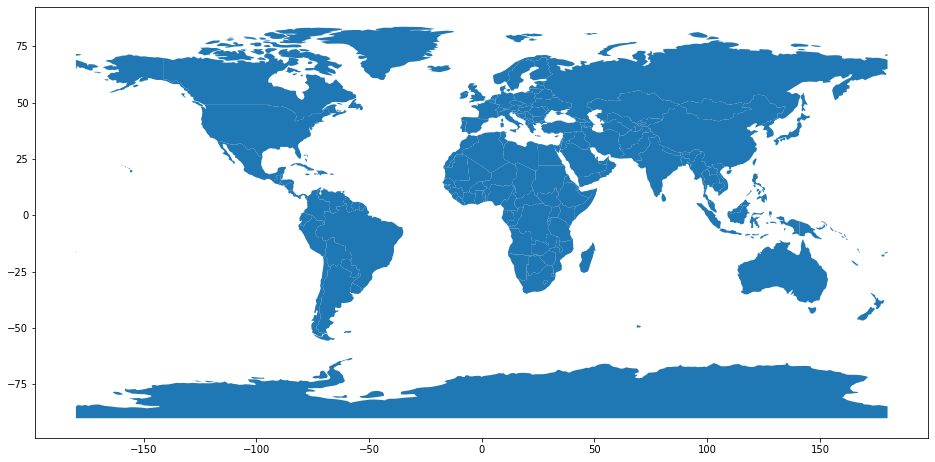

In [31]:
world.plot(figsize=[16,8])

In [32]:
from geopandas import GeoSeries
from shapely.geometry import Polygon

In [33]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [70]:
USA = world[world['name']=='United States of America']

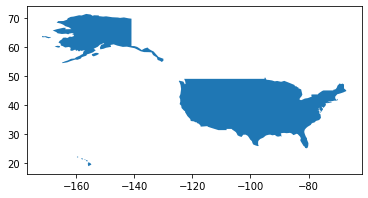

In [71]:
USA.plot()

In [68]:
type(USACAN)

pandas.core.series.Series

In [58]:
US['geometry']

4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...
Name: geometry, dtype: geometry

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


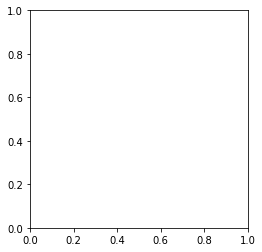

In [62]:
US.plot()

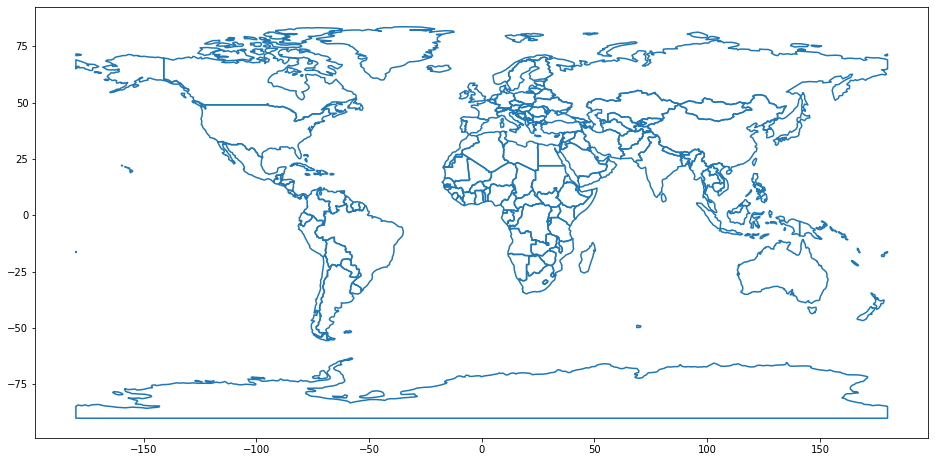

In [63]:
world.boundary.plot(figsize=[16,8])

In [40]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

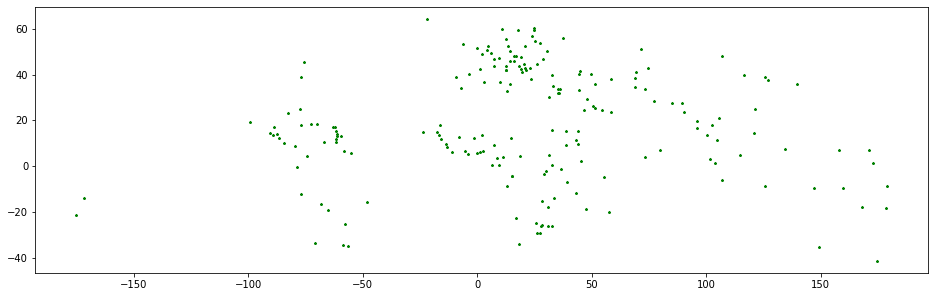

In [42]:
cities.plot(figsize=[16,8], marker='*', color='green', markersize=5)

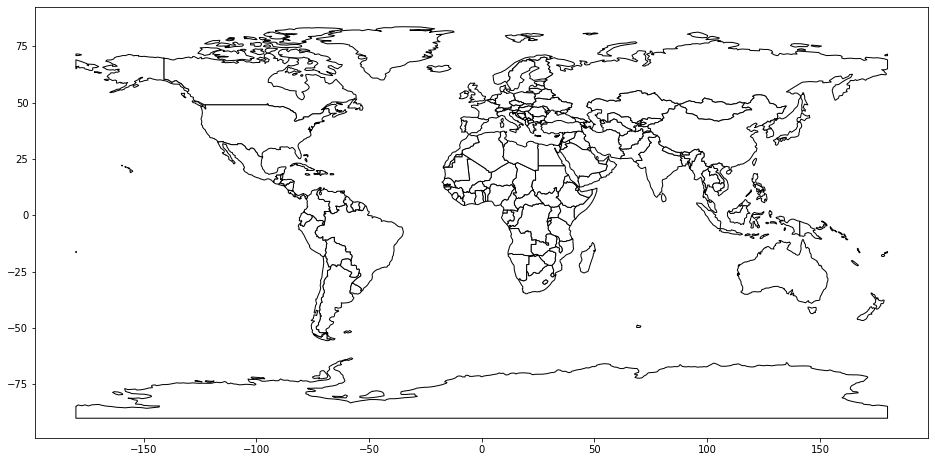

In [43]:
base = world.plot(figsize=[16,8], color='white', edgecolor='black')

In [47]:
cities.plot(figsize=[16,8], ax=base, marker='o', color='red', markersize=5) 

<Figure size 432x288 with 0 Axes>

In [50]:
cities.plot.show()

AttributeError: 'function' object has no attribute 'show'